# Karete Club Dataset

The [Karate Club](https://en.wikipedia.org/wiki/Zachary%27s_karate_club) dataset serves as an example of a graph structure. This graph represents a social network of 34 members from a karate club, documenting connections between members who interacted outside of the club. The primary goal is to detect communities that emerge from these interactions.

Much of the source code is from [here](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8?usp=sharing#scrollTo=qoW2Z7P70LNQ).

In [1]:
!pip install  torch-scatter
!pip install  torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt


def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

Looking in links: https://data.pyg.org/whl/torch-.html
  Using cached torch_sparse-0.6.18.tar.gz (209 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp310-cp310-linux_x86_64.whl size=1104576 sha256=7dd712ed44762b9e96d98e347dab266f9bd44092dd2d751e5300d6c64e337dfc
  Stored in directory: /root/.cache/pip/wheels/c9/dd/0f/a6a16f9f3b0236733d257b4b4ea91b548b984a341ed3b8f38c
Successfully built torch-sparse
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-_kbsmlt6
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-_kbsmlt6
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 46705844b39ededc0fcef1de90e73923480a6446
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f"Dataset: {dataset}")
print("--------------------")
print(f"Number of graphs: {len(dataset)}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}")

Dataset: KarateClub()
--------------------
Number of graphs: 1
Number of features: 34
Number of classes: 4


In [3]:
data = dataset[0]
print(data)

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


In [6]:
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Average node degree: {data.num_edges / data.num_nodes:.2f}")
print(f"number of training nodes: {data.train_mask.sum()}")
print(f"Training node label rate: {int(data.train_mask.sum()) / data.num_nodes}")
print(f"Has isolated nodes: {data.has_isolated_nodes()}")
print(f"Has self loops: {data.has_self_loops()}")
print(f"Is undirected: {data.is_undirected()}")


Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
number of training nodes: 4
Training node label rate: 0.11764705882352941
Has isolated nodes: False
Has self loops: False
Is undirected: True


In [7]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

edge_index = data.edge_index
print(edge_index.t())

<IPython.core.display.Javascript object>

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 

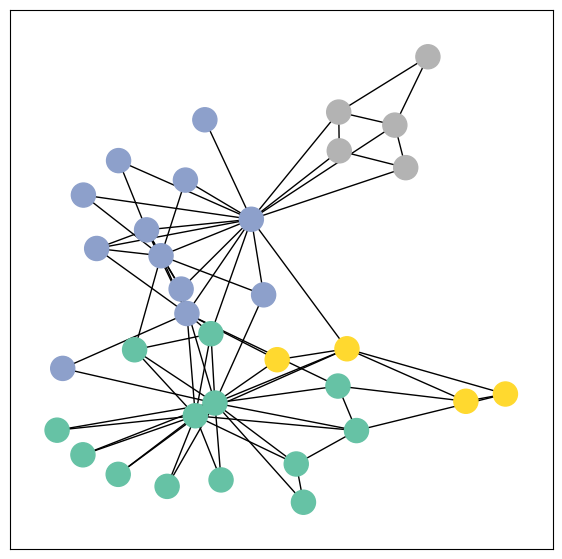

In [8]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

In [11]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    torch.manual_seed(42)
    self.conv1 = GCNConv(dataset.num_features, 4)
    self.conv2 = GCNConv(4, 4)
    self.conv3 = GCNConv(4, 2)
    self.classifier = Linear(2, dataset.num_classes)

  def forward(self, x, edge_index):
    h = self.conv1(x, edge_index)
    h = h.tanh()
    h = self.conv2(h, edge_index)
    h = h.tanh()
    h = self.conv3(h, edge_index)
    h = h.tanh()
    out = self.classifier(h)

    return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


Embedding shape: [34, 2]


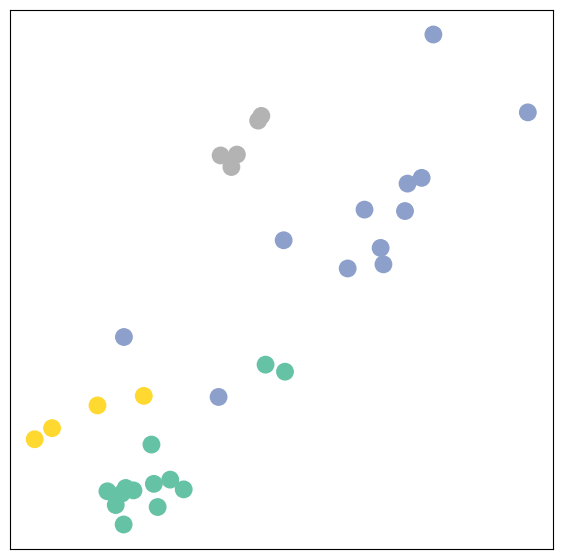

In [12]:
# Examine the node embeddings produced by the GNN by passing x, and edge_index
_, h = model(data.x, data.edge_index)
print(f"Embedding shape: {list(h.shape)}")

visualize_embedding(h, color=data.y)

<IPython.core.display.Javascript object>

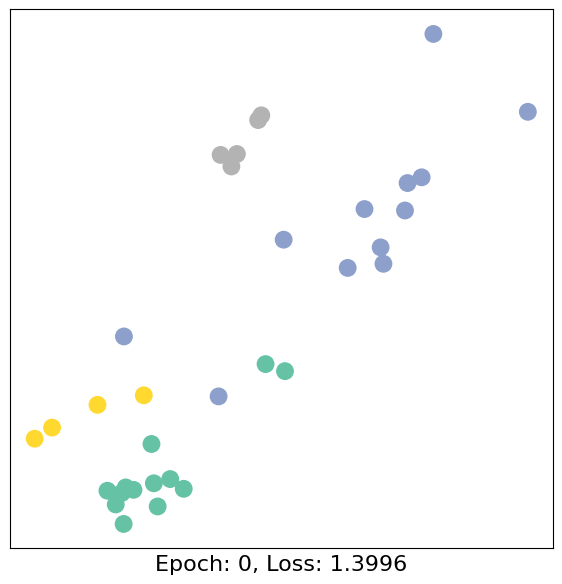

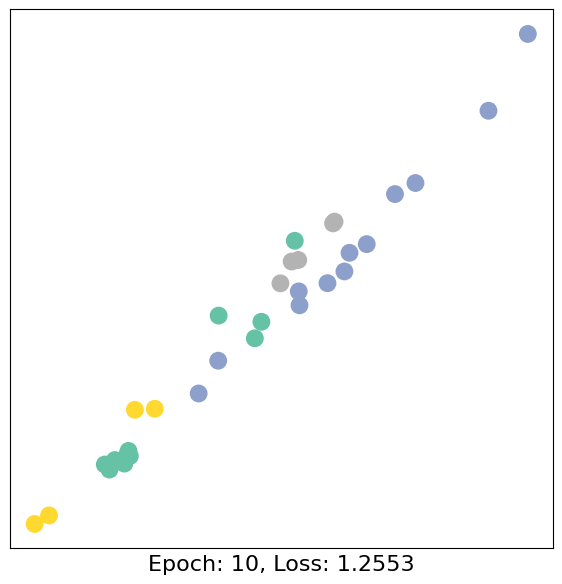

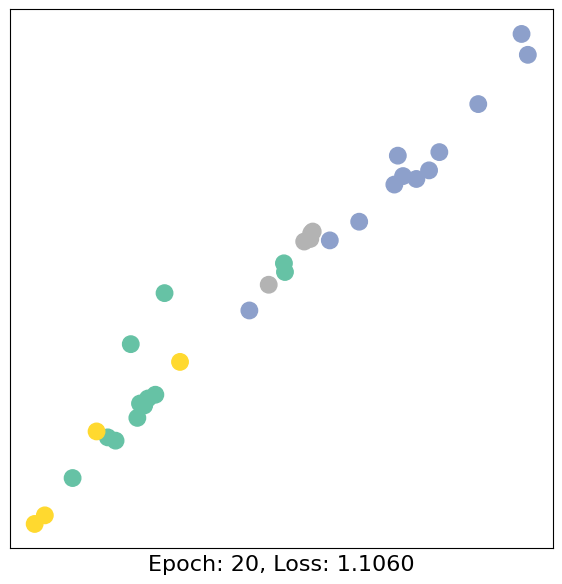

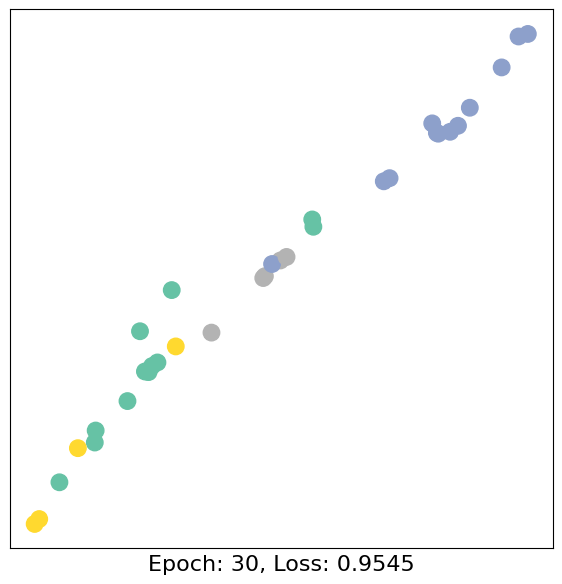

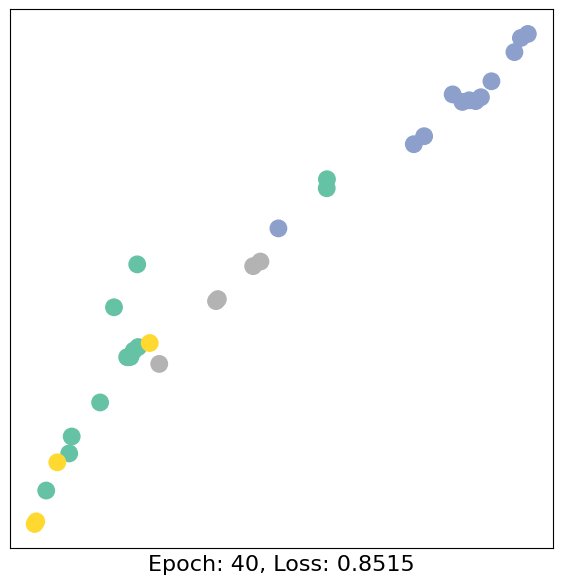

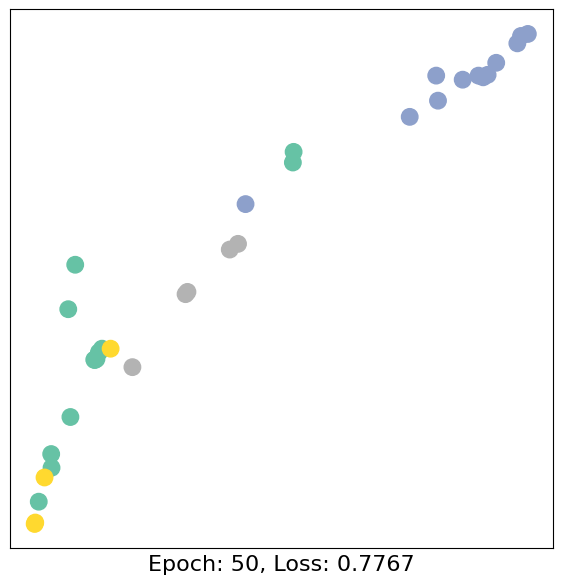

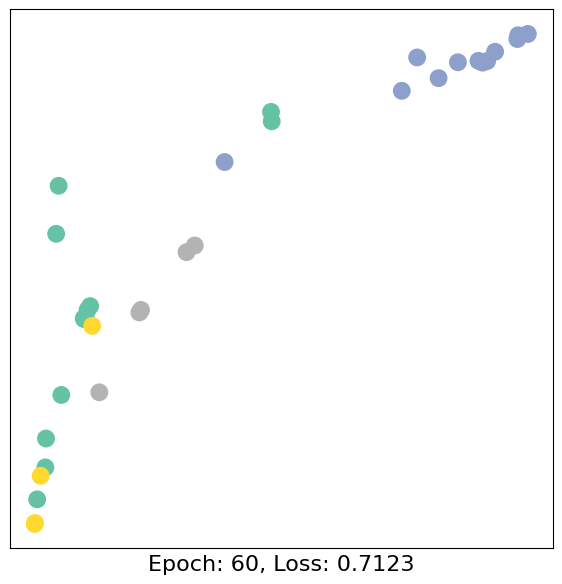

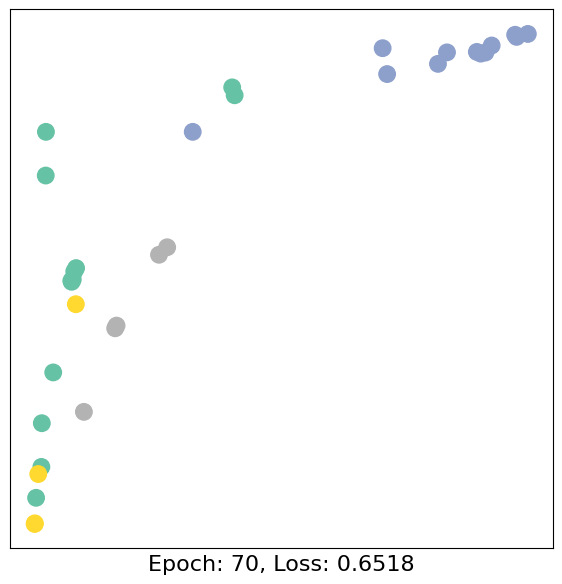

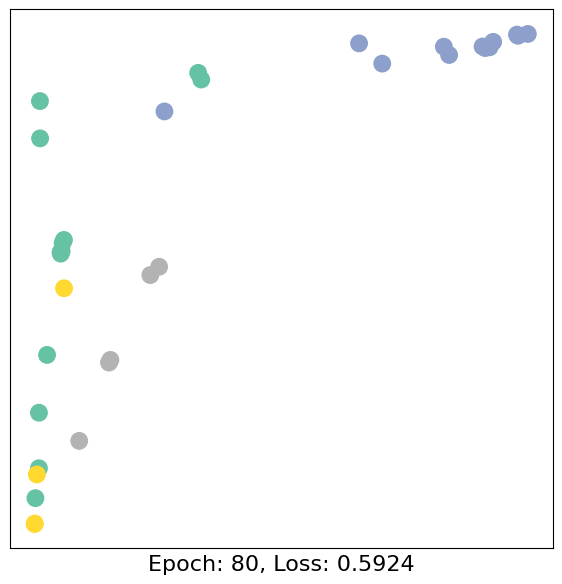

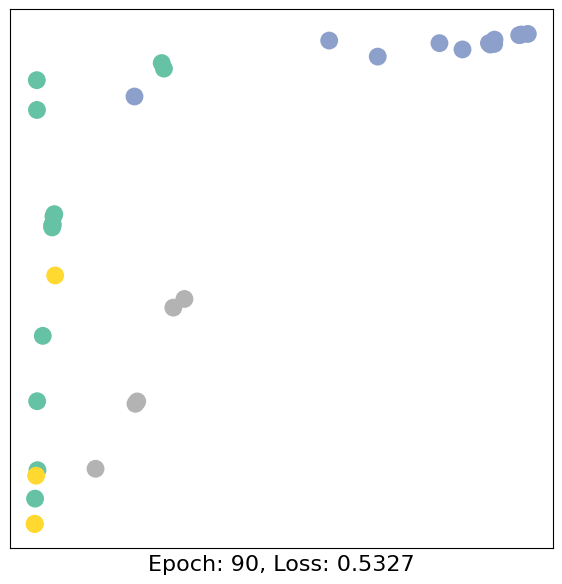

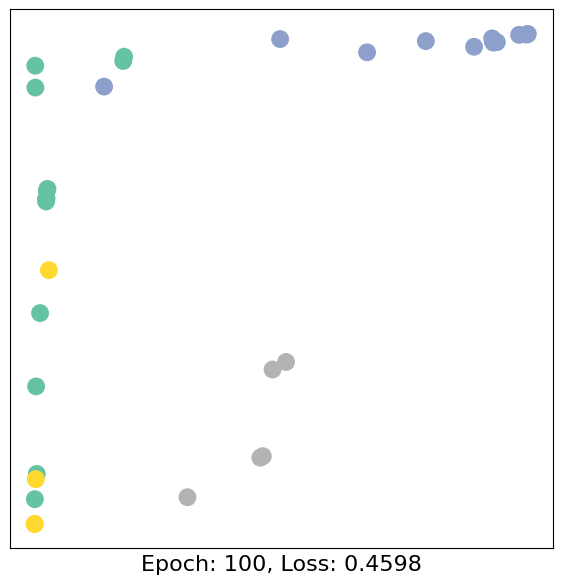

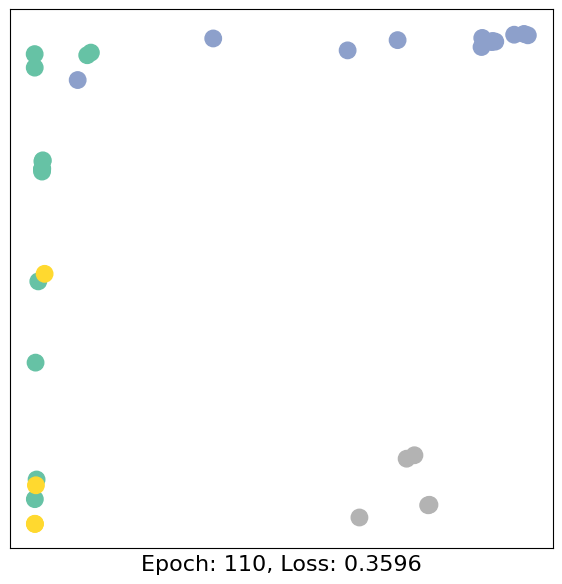

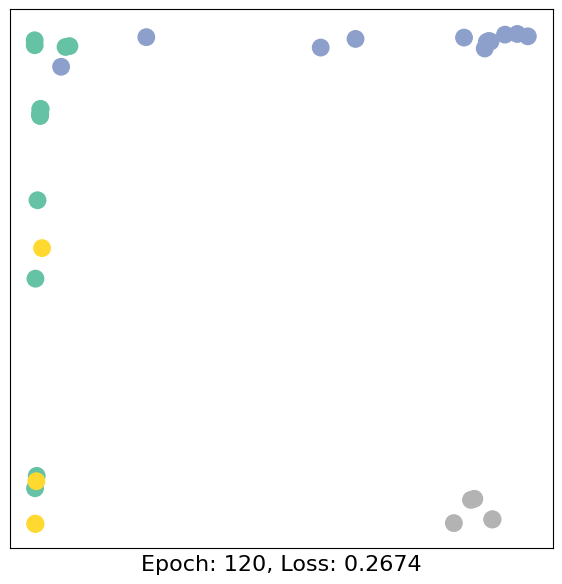

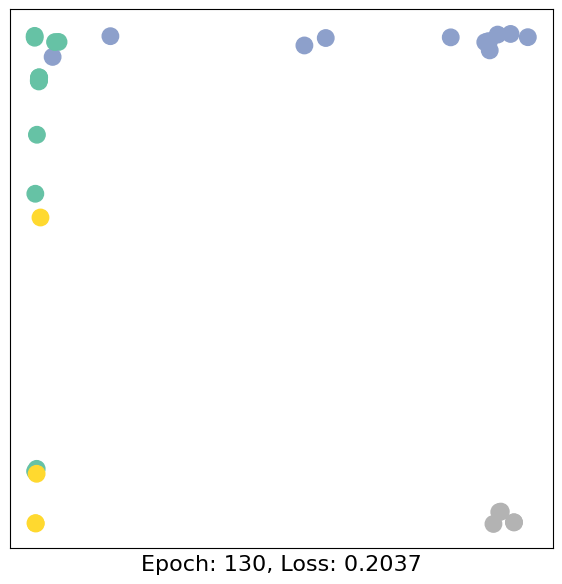

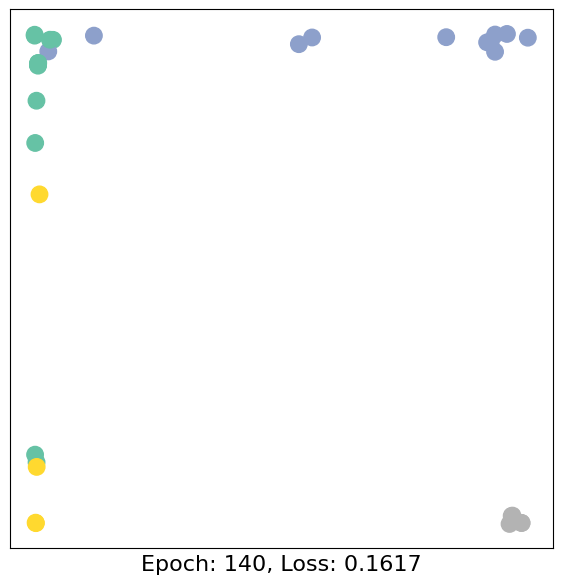

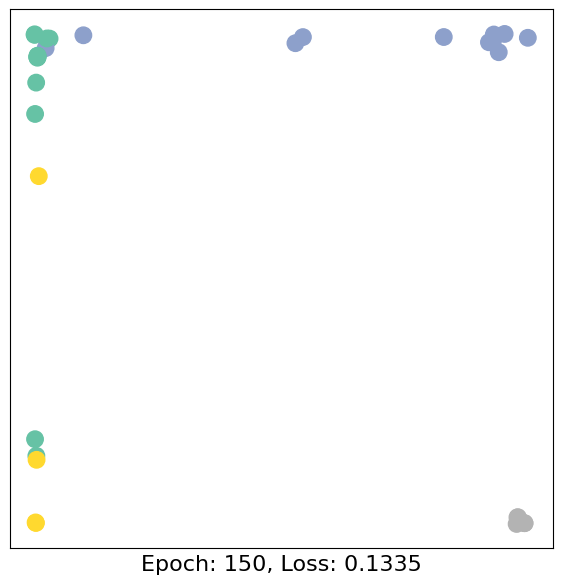

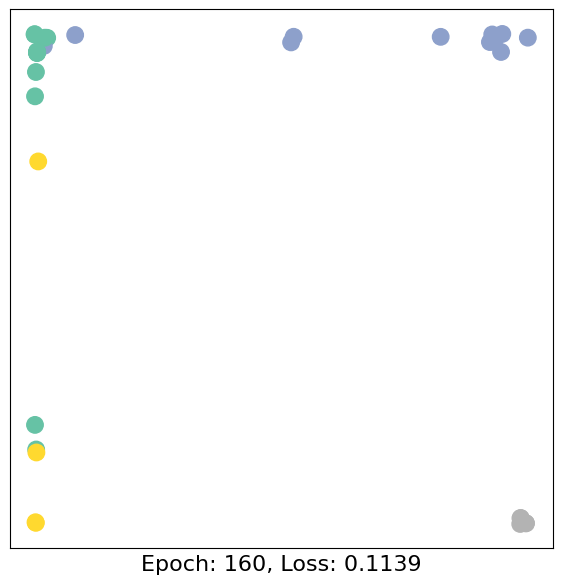

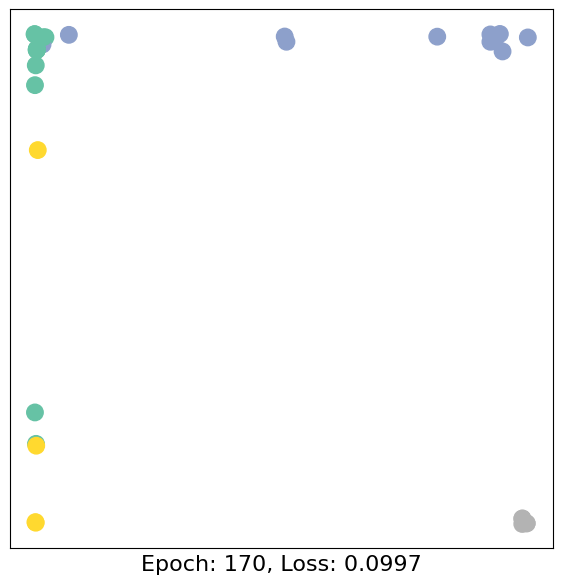

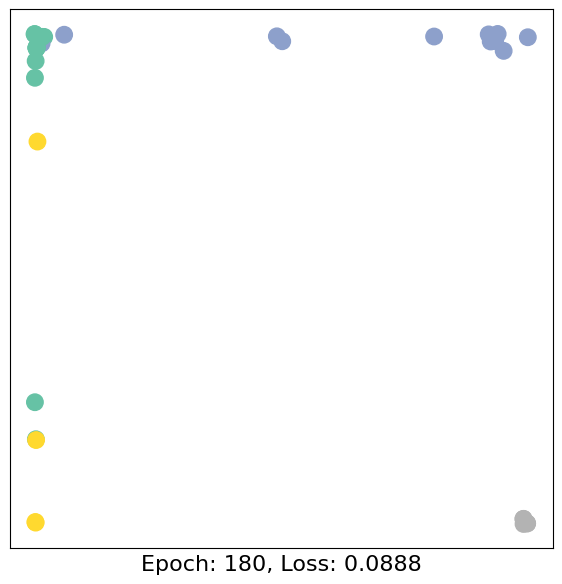

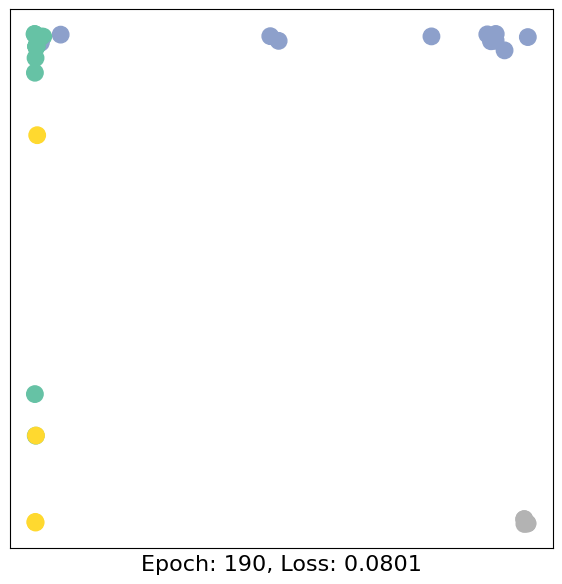

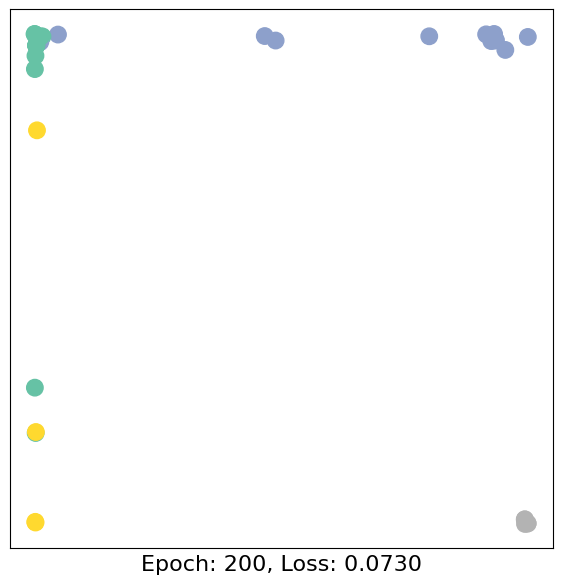

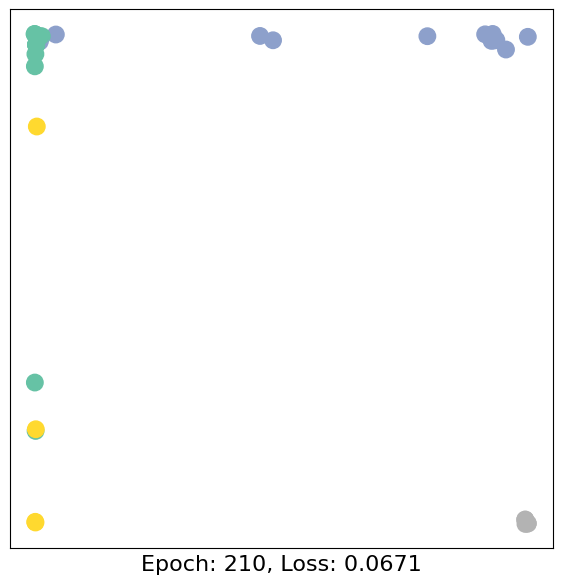

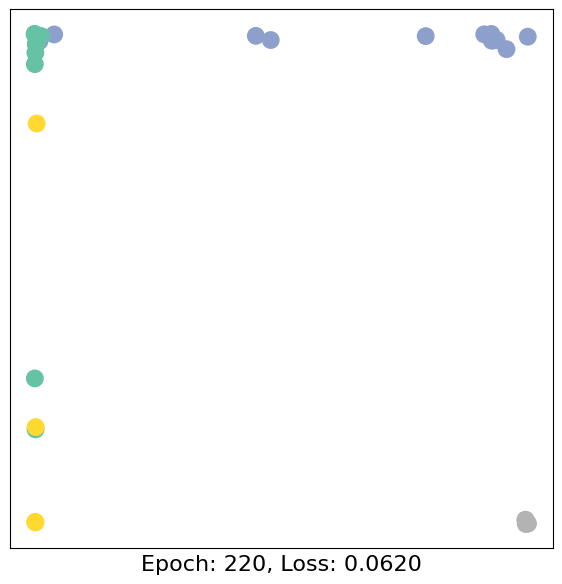

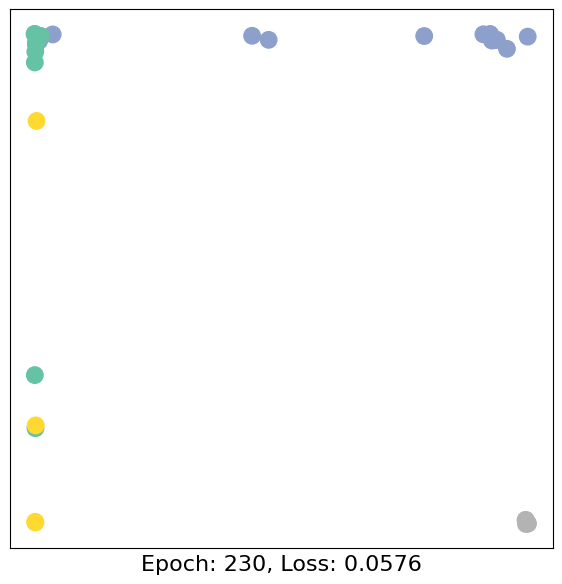

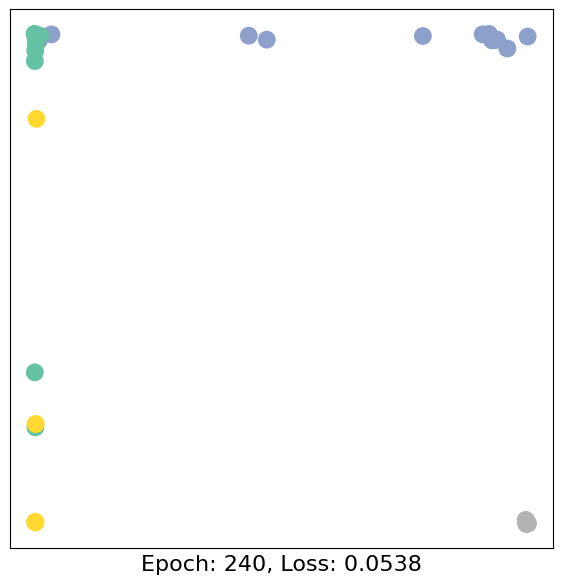

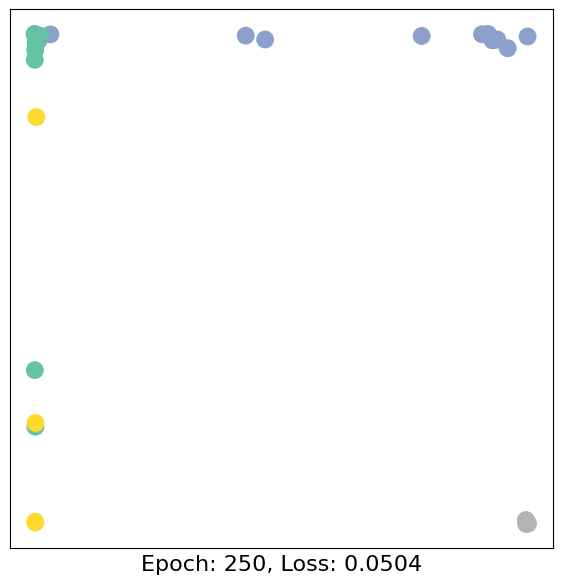

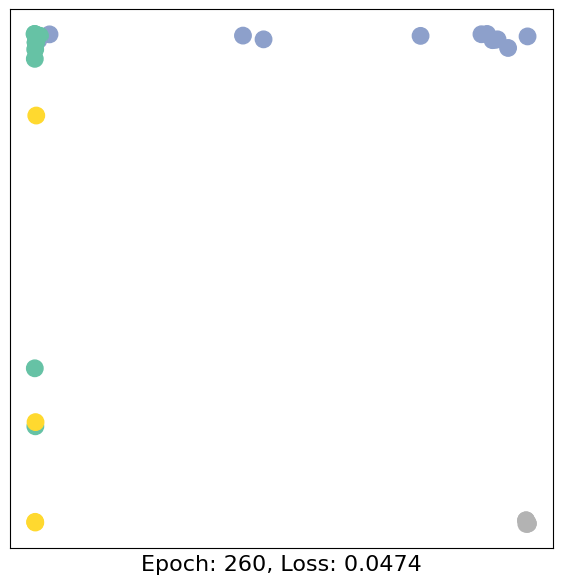

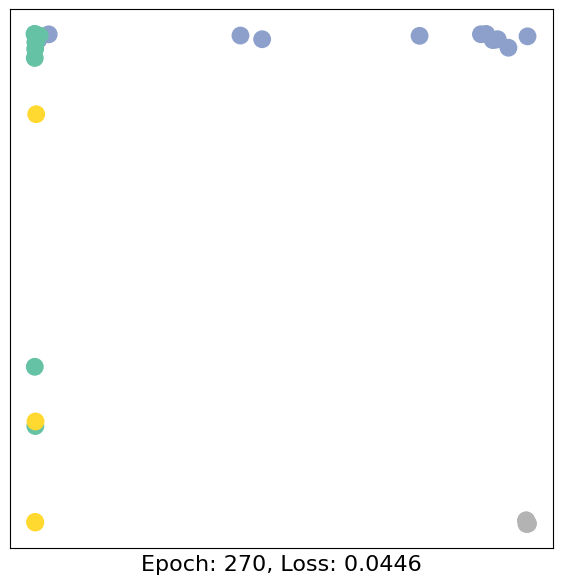

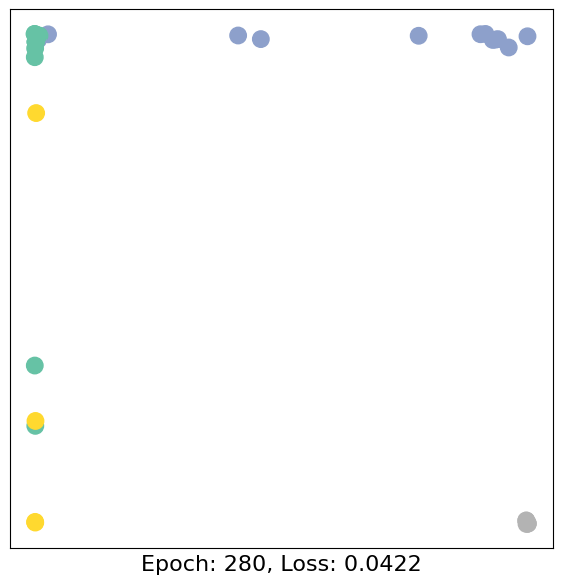

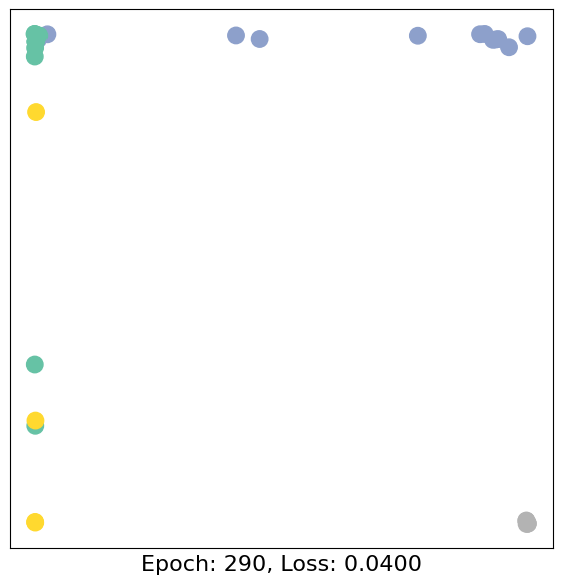

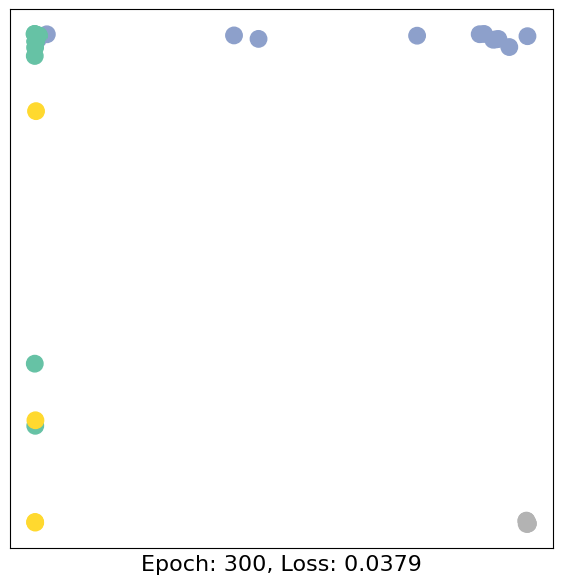

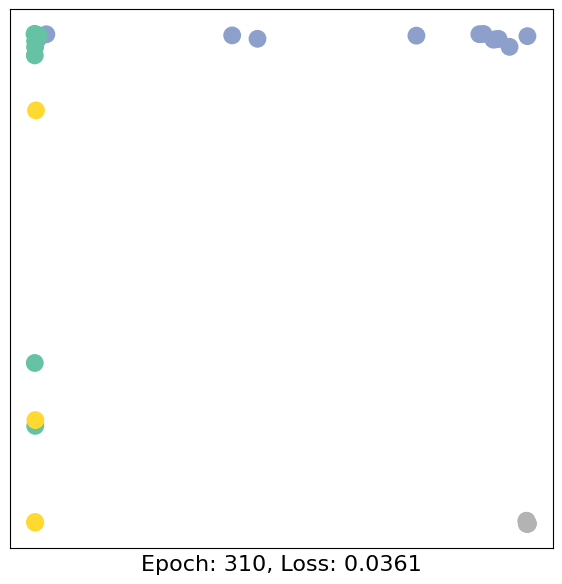

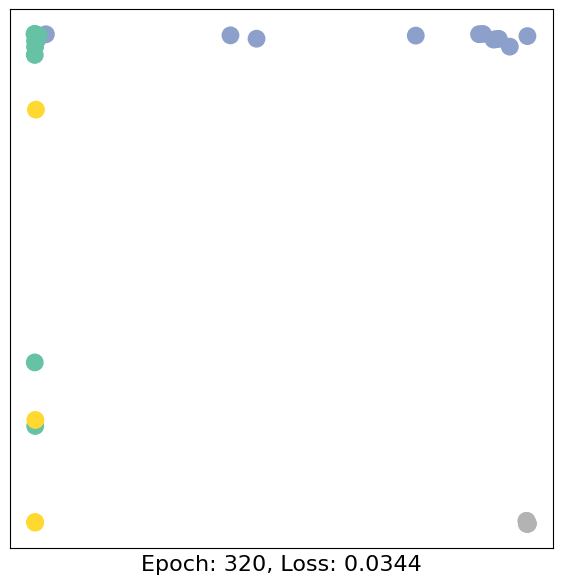

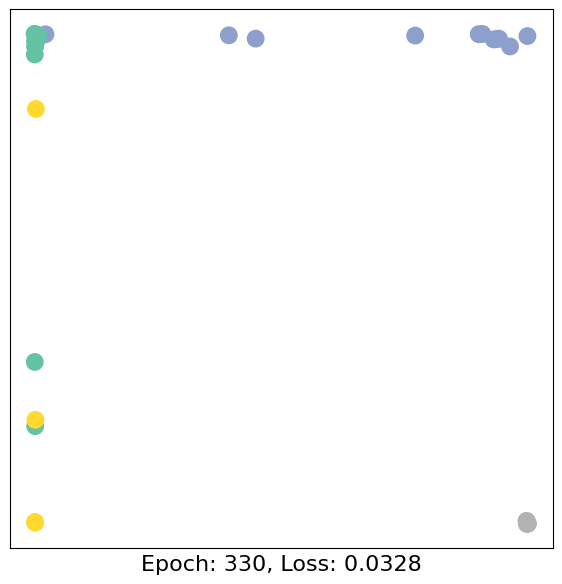

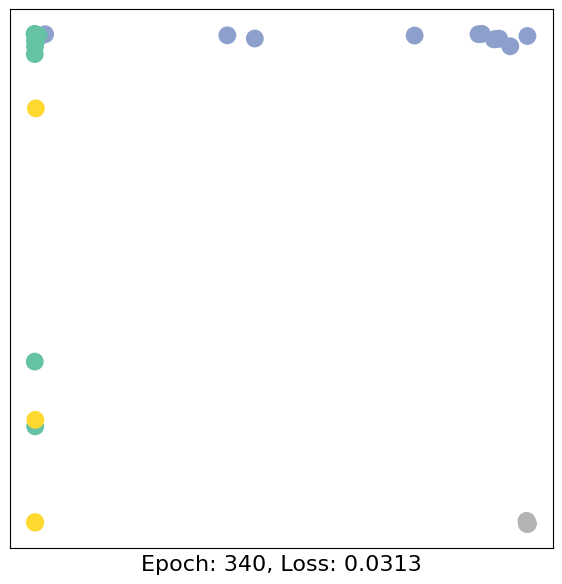

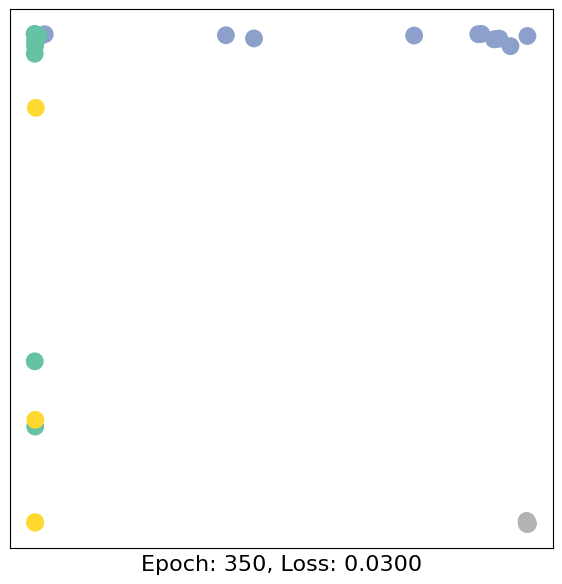

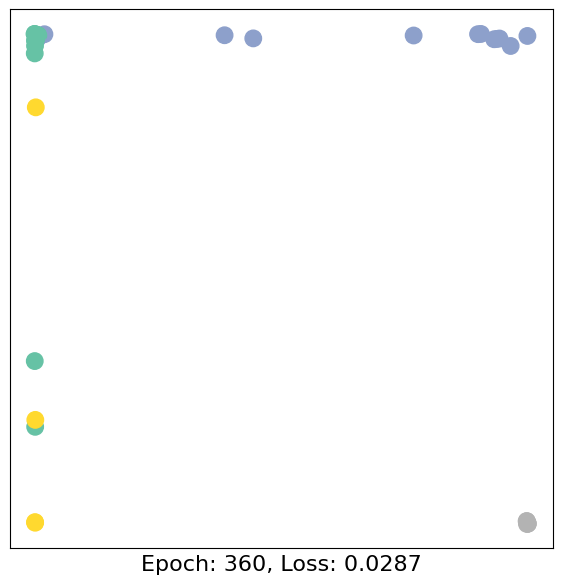

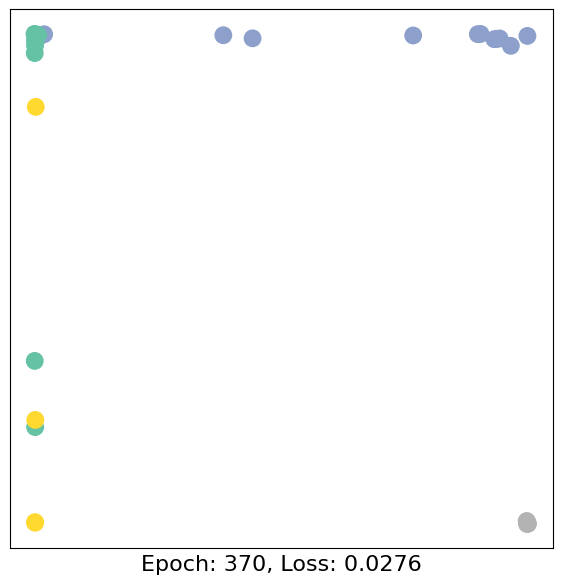

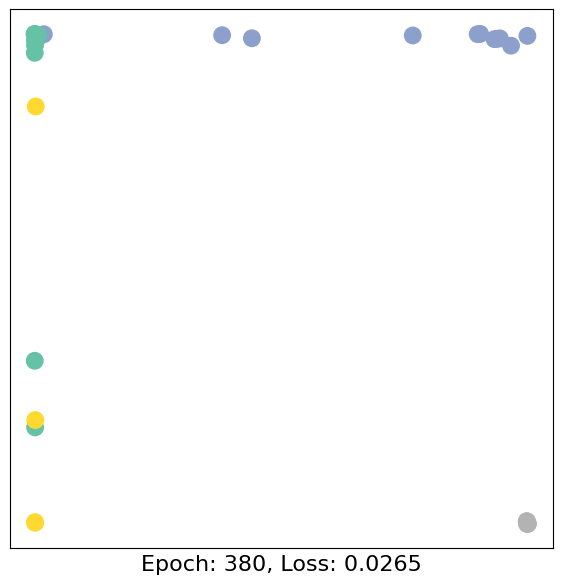

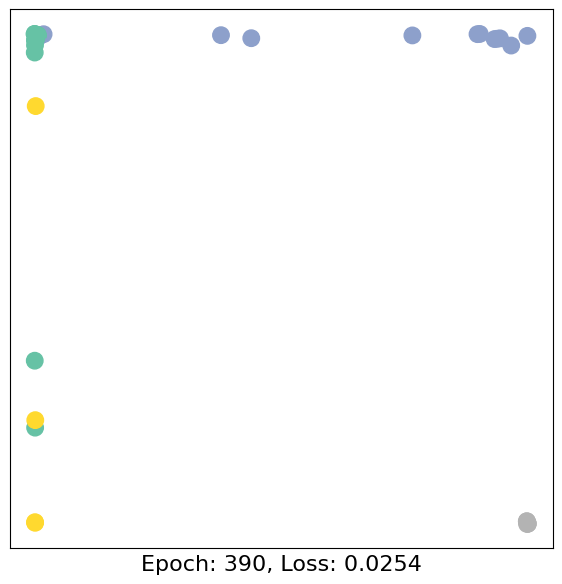

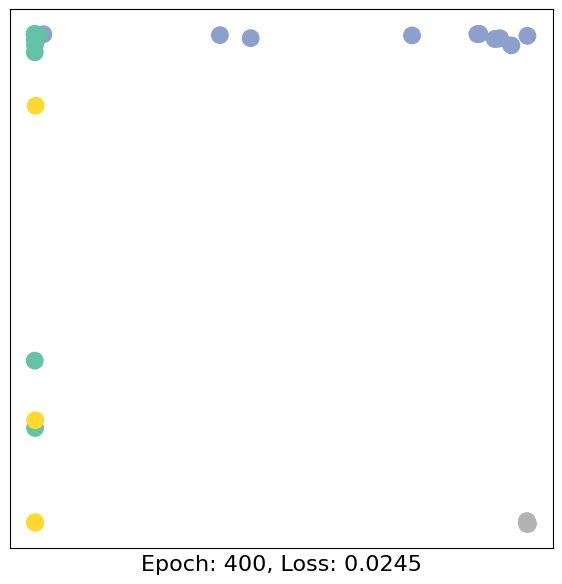

In [13]:
import time
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

model = GCN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train(data):
  optimizer.zero_grad()
  out, h = model(data.x, data.edge_index)
  loss = criterion(out[data.train_mask], data.y[data.train_mask])
  loss.backward()
  optimizer.step()
  return loss, h

for epoch in range(401):
  loss, h = train(data)
  if epoch % 10 == 0:
    visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
    time.sleep(0.3)